In [2]:

import HERA_hack
%load_ext autoreload
%autoreload 2

#these are for the telescope and observation
import numpy as np 
import numpy.linalg as la
import seaborn as sns
import pandas as pd
import os
from scipy import signal

#these are only for plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import time
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms



# Setup 

## HERA class 

#### Dishes
 - Input type: Nants x 2 array 
 - Input unit: meters
 - description: relative location of all dishes in array
#### latitude 
 - Input type: float 
 - Input unit: degree
 - description: latitude of array
 #### channel width
 - Input type: float
 - Input unit: Hz
 - description: width of channels
 #### Tsys
 - Input type: float
 - Input unit: K
 - description: brightness of system for computing rms noise
 #### Beam width
 - Input type: float 
 - Input unit: degrees
 - description: width of the primary beam
 
## Observation class 

#### Telescope                                                               
 - Input type: class 
 - Input unit: /
 - description: Telesope you're using 
####  n_days
 - Input type: float 
 - Input unit: days
 - description: number of observing days
 #### freq
 - Input type: float
 - Input unit: Hz
 - description: frequency of observation
 #### delta_t
 - Input type: float
 - Input unit: s
 - description: length of timestep
 #### acorner 
 - Input type: 4 x 2 array 
 - Input unit: degrees
 - description: observable corners of the sky 
 
 #### effective area
 - Input type: float 
 - Input unit: %
 - description: effective area of antenna
 
  #### beam sigma cutoff
 - Input type: float 
 - Input unit: standard deviations
 - description: number of standard deviation until 0 sensitivity
  #### resolution
 - Input type: float 
 - Input unit: degrees
 - description: resolution 
  #### pbeam
 - Input type: boolean
 - Input unit: /
 - description: True = include primary beam in Amat, False = do not 
  #### norm
 - Input type: boolean
 - Input unit: /
 - description: True = include norm in map, False = do not 

In [10]:
#random array of dishes 
dishes = np.array([[0,0],[50,0]])
#observable corners of the sky [lat,long]
acorner = np.array([[120,270],[122,285],[120,285],[122,270]])

#class setup
HERA = HERA_hack.telescope(dishes, latitude=-30, channel_width=1., Tsys=300, beam_width=3, beam = 'gaussian')
obs = HERA_hack.observation(HERA, 100, 100, 0.01,acorner, 1, 0.3, norm = True, pbeam = False)
    
#number of pixels in the map
npix =len(obs.observable_coordinates())

#useful VECTORS
v_rand = np.random.randn(npix) #random sky vector
imp = signal.unit_impulse(npix, 'mid') #delta funtion point source in the middle
#imp_multi = signal.unit_impulse(npix, 'mid') + signal.unit_impulse(npix, 1234) +signal.unit_impulse(npix,193)+signal.unit_impulse(npix, 687)+signal.unit_impulse(npix, 1632)+ signal.unit_impulse(npix, 122 )+signal.unit_impulse(npix, 13)+signal.unit_impulse(npix, 1344)+signal.unit_impulse(npix, 45)



#making separate arrays of theta and phi for data vis
x = np.zeros(npix)
y = np.zeros_like(x)

for i in range(len(obs.observable_coordinates())):
    x[i]= obs.observable_coordinates()[i,1] #phi
    y[i] = obs.observable_coordinates()[i,0]#theta
npix

1000

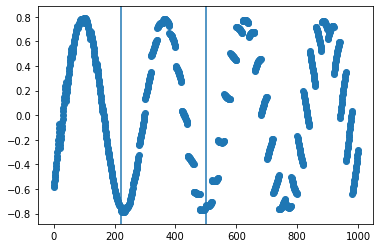

In [38]:
x1 = np.linspace(0,npix,npix)
plt.scatter(x1,np.real(obs.generate_map_noise()[:,0]))
plt.axvline(x=220)
plt.axvline(x=500)

# Map 

Here the only setting that affect this weirdness is the beam_width which what increases the range of theta coordinate we observe. Also note there is no pbeam here. that is a separate issue for another notebook...

 - beam_width = 10, you get weirdness 



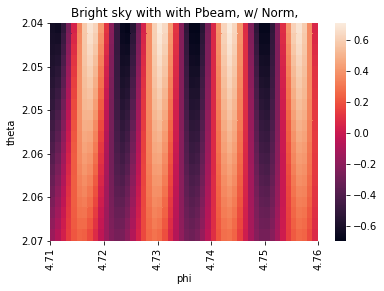

In [12]:
sky_map = np.real(obs.generate_map_noise()[:,0])



df_obs = pd.DataFrame.from_dict(np.asarray([x,y,sky_map]).T)
df_obs.columns = ['phi','theta','temp']



pivotted_obs= df_obs.pivot('theta','phi','temp')

ax = plt.axes()

sns.heatmap(pivotted_obs,ax=ax)


ax.set_title('Bright sky with with Pbeam, w/ Norm,', y = 1.04)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax.set_yticklabels([str(round(float(label), 2)) for label in ylabels])

plt.show()

# True Sky 

In [ ]:
#plotting the vector of the true sky signal
df_sky = pd.DataFrame.from_dict(np.asarray([x,y,imp]).T)
df_sky.columns = ['phi','theta','temp']
df_sky['Z_value'] = pd.to_numeric(df_obs['temp'])



pivotted_sky= df_sky.pivot('phi','theta','temp')
df_sky_transposed = pivotted_sky.transpose()

ax = plt.axes()
sns.heatmap(df_sky_transposed,ax=ax)
ax.set_title('Sky Signal')
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax.set_yticklabels([str(round(float(label), 2)) for label in ylabels])



plt.show()

# Visualisation of Primary Beam

In [ ]:
primary_beam = obs.compute_beam()[0] #primary beam at first time, 
                                    #as [i] increases, the beam drifst from left to right

df_obs = pd.DataFrame.from_dict(np.array([x,y,np.real(primary_beam)]).T)
df_obs.columns = ['phi','theta','temp']


pivotted_obs= df_obs.pivot('theta','phi','temp')

ax = plt.axes()

sns.heatmap(pivotted_obs,ax=ax)


ax.set_title('Bright sky with with Pbeam, w/ Norm,', y = 1.04)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax.set_yticklabels([str(round(float(label), 2)) for label in ylabels])

plt.show()





# Visualisation of Array

In [ ]:
#deparating x and y coordinates for each dish
x_arr = np.zeros(len(dishes))
y_arr = np.zeros(len(dishes))

for i in range(len(dishes)):
    x_arr[i]= dishes[i,0]
    y_arr[i] = dishes[i,1]


plt.scatter(x_arr,y_arr)
plt.title('My Telescope ')